# BIXI data analysis 2024

In [1]:
import pandas as pd
import geopandas as gpd
import leafmap

In [2]:
bixi = pd.read_csv('../data/raw/bixi/bixi-2024.csv')

In [3]:
bixi.head()

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS
0,Métro Champ-de-Mars (Viger / Sanguinet),Ville-Marie,45.510253,-73.556777,St-Antoine / Jean-Paul Riopelle,Ville-Marie,45.502940,-73.560640,1704230756167,1.704231e+12
1,Métro Place-d'Armes (Viger / St-Urbain),Ville-Marie,45.506314,-73.559671,de Maisonneuve / Aylmer (est),Ville-Marie,45.505386,-73.570432,1704232888826,1.704233e+12
2,Émile-Duployé / Sherbrooke,Le Plateau-Mont-Royal,45.527195,-73.564526,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704238154678,1.704239e+12
3,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Roy / St-André,Le Plateau-Mont-Royal,45.521564,-73.570367,1704232695740,1.704233e+12
4,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704243796167,1.704244e+12


In [4]:
bixi.shape[0]

13275326

In [5]:
# Create a bixi station dataframe
bixi_stations = bixi[['STARTSTATIONNAME', 'STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE']].drop_duplicates()
bixi_stations.head()

,STARTSTATIONNAME,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE
0,Métro Champ-de-Mars (Viger / Sanguinet),45.510253,-73.556777
1,Métro Place-d'Armes (Viger / St-Urbain),45.506314,-73.559671
2,Émile-Duployé / Sherbrooke,45.527195,-73.564526
3,Marmier / St-Denis,45.531027,-73.598623
5,du Parc-Lafontaine / Rachel,45.525512,-73.574245


In [6]:
# Create a GeoDataFrame from the bixi stations
gdf_bixi_stations = gpd.GeoDataFrame(bixi_stations, geometry=gpd.points_from_xy(bixi_stations.STARTSTATIONLONGITUDE, bixi_stations.STARTSTATIONLATITUDE))

In [12]:
gdf_bixi_stations = gpd.GeoDataFrame(
    bixi_stations, 
    geometry=gpd.points_from_xy(bixi_stations['STARTSTATIONLONGITUDE'], bixi_stations['STARTSTATIONLATITUDE']),
    crs='EPSG:4326'
)
gdf_bixi_stations = gdf_bixi_stations.to_crs(epsg=3857)
gdf_bixi_stations['geometry'] = gdf_bixi_stations['geometry']  # Adjust the buffer size as needed

In [13]:
m = leafmap.Map(center=[45.5, -73.6], zoom=11)
m.add_basemap("Google Maps")
m

Map(center=[45.5, -73.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [14]:
m.add_gdf(gdf_bixi_stations, layer_name="Bixi Stations", fill_colors=["Red"], radius=50)

In [15]:
# Export geo json
gdf_bixi_stations.to_file('../data/curated/bixi_stations.geojson', driver='GeoJSON')

### Analyze start and drop off count by location over 24 hours

In [16]:
# Retrieve unique start locations and keep first combination of coordinates
stations = bixi[['STARTSTATIONNAME']].drop_duplicates().rename(columns={'STARTSTATIONNAME': 'STATIONNAME'})
station_coords = bixi.groupby('STARTSTATIONNAME').first()[['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE']].reset_index()
stations = stations.merge(station_coords, left_on='STATIONNAME', right_on='STARTSTATIONNAME', how='left').drop(columns='STARTSTATIONNAME').rename(columns={'STARTSTATIONLATITUDE': 'STATIONLATITUDE', 'STARTSTATIONLONGITUDE': 'STATIONLONGITUDE'})

# Group by start and end locations, count rows and rename columns
start_counts = bixi['STARTSTATIONNAME'].value_counts().reset_index().rename(columns={'STARTSTATIONNAME': 'STARTSTATIONNAME', 'count': 'STARTCOUNT'})
end_counts = bixi['ENDSTATIONNAME'].value_counts().reset_index().rename(columns={'ENDSTATIONNAME': 'ENDSTATIONNAME', 'count': 'ENDCOUNT'})

# merge stations with start and end counts
stations_counts = stations
stations_counts = stations_counts.merge(start_counts, left_on='STATIONNAME', right_on='STARTSTATIONNAME', how='left')
stations_counts = stations_counts.merge(end_counts, left_on='STATIONNAME', right_on='ENDSTATIONNAME', how='left')

# Keep relevant columns and fill NaN values with 0
stations_counts = stations_counts[['STATIONNAME', 'STATIONLATITUDE', 'STATIONLONGITUDE', 'STARTCOUNT', 'ENDCOUNT']]

stations_counts.head()


,STATIONNAME,STATIONLATITUDE,STATIONLONGITUDE,STARTCOUNT,ENDCOUNT
0,Métro Champ-de-Mars (Viger / Sanguinet),45.510253,-73.556777,1112.0,1295.0
1,Métro Place-d'Armes (Viger / St-Urbain),45.506314,-73.559671,16325.0,30485.0
2,Émile-Duployé / Sherbrooke,45.527195,-73.564526,60132.0,55197.0
3,Marmier / St-Denis,45.531027,-73.598623,37096.0,25528.0
4,du Parc-Lafontaine / Rachel,45.525512,-73.574245,42288.0,39639.0


In [17]:
# Sort by descending order of start count and keep top 10
stations_counts_top10 = stations_counts.sort_values('STARTCOUNT', ascending=False).head(10)

stations_counts_top10.head()

,STATIONNAME,STATIONLATITUDE,STATIONLONGITUDE,STARTCOUNT,ENDCOUNT
41,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,117746.0,110896.0
15,du Mont-Royal / Clark,45.519410,-73.586850,107638.0,94981.0
82,Laurier / St-Denis,45.527148,-73.589479,84152.0,71121.0
61,des Pins / St-Laurent,45.515228,-73.575096,79154.0,72992.0
118,Marquette / du Mont-Royal,45.532218,-73.575431,78799.0,76797.0


<Axes: title={'center': 'Top 10 Bixi Station Counts'}, xlabel='STATIONNAME'>

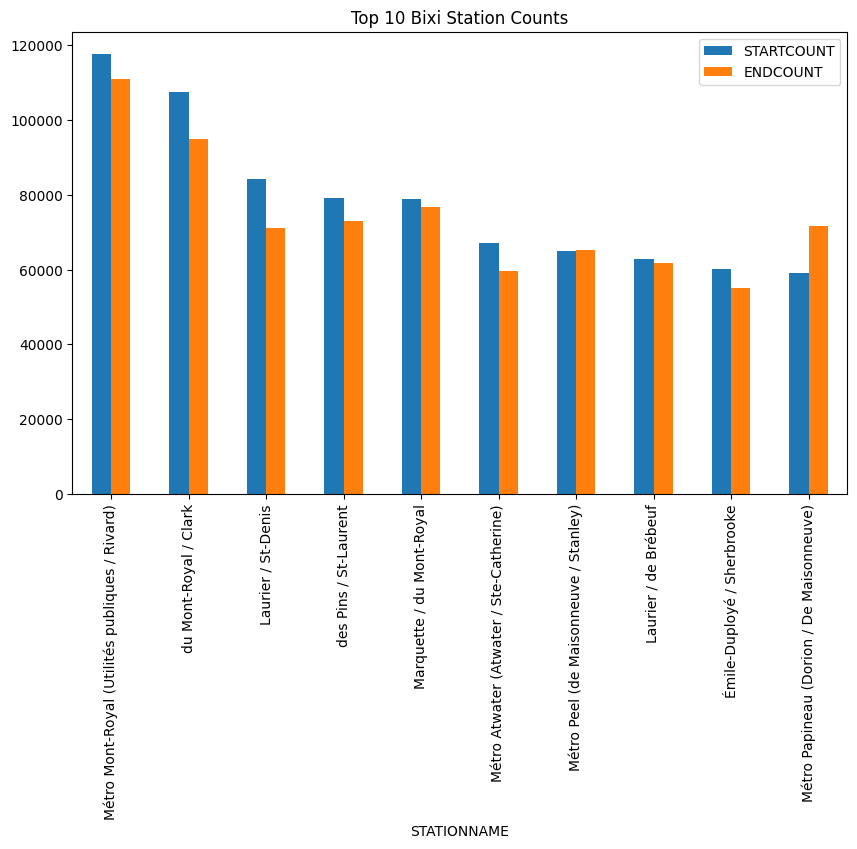

In [18]:
# Visualize top 10 station counts in a grouped column chart
stations_counts_top10[['STATIONNAME', 'STARTCOUNT', 'ENDCOUNT']].set_index('STATIONNAME').plot(kind='bar', figsize=(10, 6), title='Top 10 Bixi Station Counts')


### Update the GDF bixi stations data to look at the new df

In [20]:
# Update the gdf_bixi_stations data with the station counts
gdf_bixi_stations = gpd.GeoDataFrame(
    stations_counts,
    geometry=gpd.points_from_xy(stations_counts['STATIONLONGITUDE'], stations_counts['STATIONLATITUDE']),
    crs='EPSG:4326'
)
gdf_bixi_stations = gdf_bixi_stations.to_crs(epsg=3857)

# Normalize start and end count values
gdf_bixi_stations['STARTCOUNT_NORM'] = gdf_bixi_stations['STARTCOUNT'] / gdf_bixi_stations['STARTCOUNT'].max()
gdf_bixi_stations['ENDCOUNT_NORM'] = gdf_bixi_stations['ENDCOUNT'] / gdf_bixi_stations['STARTCOUNT'].max()

# Split into two GeoDataFrames for start and end counts
gdf_bixi_stations_start = gdf_bixi_stations[['STATIONNAME', 'STARTCOUNT', 'STARTCOUNT_NORM', 'geometry']].copy()
gdf_bixi_stations_end = gdf_bixi_stations[['STATIONNAME', 'ENDCOUNT', 'ENDCOUNT_NORM', 'geometry']].copy()

# Create buffer based on normalized counts for start and end counts
gdf_bixi_stations_start['geometry'] = gdf_bixi_stations_start['geometry'].buffer(gdf_bixi_stations_start['STARTCOUNT_NORM'] * 100)
gdf_bixi_stations_end['geometry'] = gdf_bixi_stations_end['geometry'].buffer(gdf_bixi_stations_end['ENDCOUNT_NORM'] * 100)

In [21]:
# Visualize the start and end radius on the map
m_counts = leafmap.Map(center=[45.5, -73.6], zoom=11)
m_counts.add_basemap("Google Maps")

# Add GeoDataFrames to the map with adjusted parameters
m_counts.add_gdf(gdf_bixi_stations_start, layer_name="Bixi Start Counts", fill_colors=["Green"], radius=20)
m_counts.add_gdf(gdf_bixi_stations_end, layer_name="Bixi End Counts", fill_colors=["Red"], radius=20)

In [22]:
m_counts

Map(center=[45.5, -73.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

### Create hour column to bixi data

In [23]:
# Transform STARTTIMEMS	and ENDTIMEMS into datetime
bixi['STARTTIMEMS'] = pd.to_datetime(bixi['STARTTIMEMS'], unit='ms')
bixi['ENDTIMEMS'] = pd.to_datetime(bixi['ENDTIMEMS'], unit='ms')

bixi[['STARTTIMEMS', 'ENDTIMEMS']].head()

,STARTTIMEMS,ENDTIMEMS
0,2024-01-02 21:25:56.167,2024-01-02 21:31:46.232
1,2024-01-02 22:01:28.826,2024-01-02 22:08:23.502
2,2024-01-02 23:29:14.678,2024-01-02 23:49:19.500
3,2024-01-02 21:58:15.740,2024-01-02 22:08:49.014
4,2024-01-03 01:03:16.167,2024-01-03 01:14:44.511


In [24]:
# Get hour of day
bixi['STARTHOUR'] = bixi['STARTTIMEMS'].dt.hour
bixi['ENDHOUR'] = bixi['ENDTIMEMS'].dt.hour

bixi[['STARTHOUR', 'ENDHOUR']].head()

,STARTHOUR,ENDHOUR
0,21,21.0
1,22,22.0
2,23,23.0
3,21,22.0
4,1,1.0


In [25]:
# Group bixi data by 10 minutes intervals
bixi['STARTTIME10'] = bixi['STARTTIMEMS'].dt.floor('10min').dt.time
bixi['ENDTIME10'] = bixi['ENDTIMEMS'].dt.floor('10min').dt.time

bixi[['STARTTIME10', 'ENDTIME10']].head()

,STARTTIME10,ENDTIME10
0,21:20:00,21:30:00
1,22:00:00,22:00:00
2,23:20:00,23:40:00
3,21:50:00,22:00:00
4,01:00:00,01:10:00


In [26]:
# Checking if duplication took place by getting the total trips before and after the merge
bixi.shape[0], stations_counts['STARTCOUNT'].sum(), stations_counts['ENDCOUNT'].sum()

(13275326, np.float64(13274083.0), np.float64(13202822.0))

In [27]:
# Group by station name and start time
# Retrieve unique start locations and keep first combination of coordinates
stations = bixi[['STARTSTATIONNAME']].drop_duplicates().rename(columns={'STARTSTATIONNAME': 'STATIONNAME'})

# generate 10 minute interval between 0 and 24 hours
time_intervals = pd.date_range('2024-01-01', periods=144, freq='10min').time

# Create a dataframe with all possible combinations of stations and time intervals
stations_10min = pd.DataFrame()
for time in time_intervals:
    stations['TIME'] = time
    stations_10min = pd.concat([stations_10min, stations])

# Sort by station name and time
stations_10min = stations_10min.sort_values(['STATIONNAME', 'TIME']).reset_index(drop=True)

stations_10min.head(), stations_10min.shape[0]

(           STATIONNAME      TIME
 0  10e avenue / Masson  00:00:00
 1  10e avenue / Masson  00:10:00
 2  10e avenue / Masson  00:20:00
 3  10e avenue / Masson  00:30:00
 4  10e avenue / Masson  00:40:00,
 162720)

In [28]:
# Add coordinates to the stations_10min dataframe
station_coords = bixi.groupby('STARTSTATIONNAME').first()[['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE']].reset_index()
station_coords = station_coords.rename(columns={'STARTSTATIONLATITUDE': 'STATIONLATITUDE', 'STARTSTATIONLONGITUDE': 'STATIONLONGITUDE'})

stations_10min = stations_10min.merge(station_coords, left_on='STATIONNAME', right_on='STARTSTATIONNAME', how='left').drop(columns='STARTSTATIONNAME').rename(columns={'STATIONLATITUDE': 'LATITUDE', 'STATIONLONGITUDE': 'LONGITUDE'})

stations_10min.head(), stations_10min.shape[0]

(           STATIONNAME      TIME   LATITUDE  LONGITUDE
 0  10e avenue / Masson  00:00:00  45.550377 -73.573734
 1  10e avenue / Masson  00:10:00  45.550377 -73.573734
 2  10e avenue / Masson  00:20:00  45.550377 -73.573734
 3  10e avenue / Masson  00:30:00  45.550377 -73.573734
 4  10e avenue / Masson  00:40:00  45.550377 -73.573734,
 162720)

In [29]:
# Add start and end counts to the stations_10min dataframe
start_counts = bixi.groupby(['STARTSTATIONNAME', 'STARTTIME10']).size().reset_index(name='STARTCOUNT')
end_counts = bixi.groupby(['ENDSTATIONNAME', 'ENDTIME10']).size().reset_index(name='ENDCOUNT')

stations_10min = stations_10min.merge(start_counts, left_on=['STATIONNAME', 'TIME'], right_on=['STARTSTATIONNAME', 'STARTTIME10'], how='left')
stations_10min = stations_10min.merge(end_counts, left_on=['STATIONNAME', 'TIME'], right_on=['ENDSTATIONNAME', 'ENDTIME10'], how='left')

# Fill NaN values with 0
stations_10min = stations_10min.fillna(0)

# Delete rows with invalid station names
stations_10min = stations_10min[stations_10min['STATIONNAME'] != 0]

stations_10min.head()

,STATIONNAME,TIME,LATITUDE,LONGITUDE,STARTSTATIONNAME,STARTTIME10,STARTCOUNT,ENDSTATIONNAME,ENDTIME10,ENDCOUNT
0,10e avenue / Masson,00:00:00,45.550377,-73.573734,10e avenue / Masson,00:00:00,260.0,10e avenue / Masson,00:00:00,289.0
1,10e avenue / Masson,00:10:00,45.550377,-73.573734,10e avenue / Masson,00:10:00,256.0,10e avenue / Masson,00:10:00,257.0
2,10e avenue / Masson,00:20:00,45.550377,-73.573734,10e avenue / Masson,00:20:00,219.0,10e avenue / Masson,00:20:00,232.0
3,10e avenue / Masson,00:30:00,45.550377,-73.573734,10e avenue / Masson,00:30:00,242.0,10e avenue / Masson,00:30:00,223.0
4,10e avenue / Masson,00:40:00,45.550377,-73.573734,10e avenue / Masson,00:40:00,214.0,10e avenue / Masson,00:40:00,210.0


In [30]:
# Keep relevant columns and add a geometry column
stations_10min = stations_10min[['STATIONNAME', 'LATITUDE', 'LONGITUDE', 'TIME', 'STARTCOUNT', 'ENDCOUNT']]
stations_10min = gpd.GeoDataFrame(
    stations_10min,
    geometry=gpd.points_from_xy(stations_10min['LONGITUDE'], stations_10min['LATITUDE']),
    crs='EPSG:4326'
)

stations_10min.head()

,STATIONNAME,LATITUDE,LONGITUDE,TIME,STARTCOUNT,ENDCOUNT,geometry
0,10e avenue / Masson,45.550377,-73.573734,00:00:00,260.0,289.0,POINT (-73.57373 45.55038)
1,10e avenue / Masson,45.550377,-73.573734,00:10:00,256.0,257.0,POINT (-73.57373 45.55038)
2,10e avenue / Masson,45.550377,-73.573734,00:20:00,219.0,232.0,POINT (-73.57373 45.55038)
3,10e avenue / Masson,45.550377,-73.573734,00:30:00,242.0,223.0,POINT (-73.57373 45.55038)
4,10e avenue / Masson,45.550377,-73.573734,00:40:00,214.0,210.0,POINT (-73.57373 45.55038)


In [31]:
# Normalize start and end count values
stations_10min['STARTCOUNT_NORM'] = stations_10min['STARTCOUNT'] / stations_10min['STARTCOUNT'].max()
stations_10min['ENDCOUNT_NORM'] = stations_10min['ENDCOUNT'] / stations_10min['STARTCOUNT'].max()

stations_10min.head()

,STATIONNAME,LATITUDE,LONGITUDE,TIME,STARTCOUNT,ENDCOUNT,geometry,STARTCOUNT_NORM,ENDCOUNT_NORM
0,10e avenue / Masson,45.550377,-73.573734,00:00:00,260.0,289.0,POINT (-73.57373 45.55038),0.125060,0.139009
1,10e avenue / Masson,45.550377,-73.573734,00:10:00,256.0,257.0,POINT (-73.57373 45.55038),0.123136,0.123617
2,10e avenue / Masson,45.550377,-73.573734,00:20:00,219.0,232.0,POINT (-73.57373 45.55038),0.105339,0.111592
3,10e avenue / Masson,45.550377,-73.573734,00:30:00,242.0,223.0,POINT (-73.57373 45.55038),0.116402,0.107263
4,10e avenue / Masson,45.550377,-73.573734,00:40:00,214.0,210.0,POINT (-73.57373 45.55038),0.102934,0.101010


In [32]:
# Create a delta column for start and end counts
stations_10min['DELTA'] = stations_10min['STARTCOUNT'] - stations_10min['ENDCOUNT']

# Normalize delta values
stations_10min['DELTA_NORM'] = stations_10min['DELTA'] / stations_10min['DELTA'].max()

stations_10min

,STATIONNAME,LATITUDE,LONGITUDE,TIME,STARTCOUNT,ENDCOUNT,geometry,STARTCOUNT_NORM,ENDCOUNT_NORM,DELTA,DELTA_NORM
0,10e avenue / Masson,45.550377,-73.573734,00:00:00,260.0,289.0,POINT (-73.57373 45.55038),0.125060,0.139009,-29.0,-0.035802
1,10e avenue / Masson,45.550377,-73.573734,00:10:00,256.0,257.0,POINT (-73.57373 45.55038),0.123136,0.123617,-1.0,-0.001235
2,10e avenue / Masson,45.550377,-73.573734,00:20:00,219.0,232.0,POINT (-73.57373 45.55038),0.105339,0.111592,-13.0,-0.016049
3,10e avenue / Masson,45.550377,-73.573734,00:30:00,242.0,223.0,POINT (-73.57373 45.55038),0.116402,0.107263,19.0,0.023457
4,10e avenue / Masson,45.550377,-73.573734,00:40:00,214.0,210.0,POINT (-73.57373 45.55038),0.102934,0.101010,4.0,0.004938
...,...,...,...,...,...,...,...,...,...,...,...
162571,Émile-Journault / de Châteaubriand,45.549712,-73.640691,23:10:00,77.0,66.0,POINT (-73.64069 45.54971),0.037037,0.031746,11.0,0.013580
162572,Émile-Journault / de Châteaubriand,45.549712,-73.640691,23:20:00,92.0,85.0,POINT (-73.64069 45.54971),0.044252,0.040885,7.0,0.008642
162573,Émile-Journault / de Châteaubriand,45.549712,-73.640691,23:30:00,70.0,94.0,POINT (-73.64069 45.54971),0.033670,0.045214,-24.0,-0.029630
162574,Émile-Journault / de Châteaubriand,45.549712,-73.640691,23:40:00,62.0,82.0,POINT (-73.64069 45.54971),0.029822,0.039442,-20.0,-0.024691


In [33]:
# Transform time to string
stations_10min['TIME'] = stations_10min['TIME'].astype(str)

In [34]:
filtered_data = stations_10min[stations_10min['TIME'] == '17:10:00']

# Recalculate the geometry points
filtered_data = gpd.GeoDataFrame(
    filtered_data,
    geometry=gpd.points_from_xy(filtered_data['LONGITUDE'], filtered_data['LATITUDE']),
    crs='EPSG:4326'
)


# Convert to a projected CRS
filtered_data = filtered_data.to_crs(epsg=3857)

# Split into two GeoDataFrames for positive and negative deltas
positive_data = filtered_data[filtered_data['DELTA'] > 0]
negative_data = filtered_data[filtered_data['DELTA'] < 0]

# Create buffer based on normalized delta values
positive_data['geometry'] = positive_data['geometry'].buffer(abs(positive_data['DELTA_NORM']) * 1000)
negative_data['geometry'] = negative_data['geometry'].buffer(abs(negative_data['DELTA_NORM']) * 1000)

# Visualize the positive and negative deltas on the map
m_deltas = leafmap.Map(center=[45.52, -73.6], zoom=13)
m_deltas.add_basemap("Google Maps")

# Add GeoDataFrames to the map with adjusted parameters
#m_deltas.add_gdf(positive_data, layer_name="Positive Deltas", fill_colors=["Green"], radius=20)
#m_deltas.add_gdf(negative_data, layer_name="Negative Deltas", fill_colors=["Red"], radius=20)

m_deltas

Map(center=[45.52, -73.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [39]:
# Filter data for between 17:00:00 and 18:00:00
stations_10min['TIME'] = stations_10min['TIME'].astype(str)
filtered_data = stations_10min[(stations_10min['TIME'] >= '17:00:00') & (stations_10min['TIME'] < '18:00:00')]

time_intervals = pd.unique(filtered_data['TIME'])

layers_dict = {}

for time in time_intervals:
    # Filter data for the current time interval
    time_filtered_data = filtered_data[filtered_data['TIME'] == time]

    # add layer to the dictionary
    layers_dict[f"Delta {str(time)}"] = time_filtered_data

    # Recalculate the geometry points
    time_filtered_data = gpd.GeoDataFrame(
        time_filtered_data,
        geometry=gpd.points_from_xy(time_filtered_data['LONGITUDE'], time_filtered_data['LATITUDE']),
        crs='EPSG:4326'
    )

    # Convert to a projected CRS
    time_filtered_data = time_filtered_data.to_crs(epsg=3857)

    # Split into two GeoDataFrames for positive and negative deltas
    positive_data = time_filtered_data[time_filtered_data['DELTA'] > 0]
    negative_data = time_filtered_data[time_filtered_data['DELTA'] < 0]

    # Create buffer based on normalized delta values
    positive_data['geometry'] = positive_data['geometry'].buffer(abs(positive_data['DELTA_NORM']) * 1000)
    negative_data['geometry'] = negative_data['geometry'].buffer(abs(negative_data['DELTA_NORM']) * 1000)

    # Combine positive and negative data into one GeoDataFrame
    combined_data = pd.concat([positive_data, negative_data])

    # Add the combined data to the map with visibility set to False
    m_deltas.add_gdf(combined_data, layer_name=f"Delta {str(time)}", fill_colors=["Green" if x > 0 else "Red" for x in combined_data['DELTA']], visible=False)

In [37]:
# Export station start stop counts
stations_10min_gdf = gpd.GeoDataFrame(
    stations_10min,
    geometry=gpd.points_from_xy(stations_10min['LONGITUDE'], stations_10min['LATITUDE']),
    crs='EPSG:4326'
)

stations_10min_gdf = stations_10min_gdf.to_crs(epsg=3857)

stations_10min_gdf.to_file('../data/curated/bixi_stations_10min_counts.geojson', driver='GeoJSON')